# Titanic Data Analysis
## Goal of Analysis: Use machine learning algorithms to get best accuracy of predictions for who survived the sinking of the Titanic given the attributes in the dataset. 

In [1]:
import os
os.environ['PATH'] = os.environ['PATH'] + r";C:\Apps\Graphviz\bin"

In [2]:
import sys
!{sys.executable} -m pip install pandas-profiling pydotplus keras tensorflow graphviz

In [3]:
#Imports 
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import preprocessing
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
import graphviz

# Data Analysis

In [4]:
titanic_df = pd.read_csv("titanic_data.csv")
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
 10  Survived  1309 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


## Data Exploration

In [5]:
titanic_df.describe()

Pclass          Age        SibSp        Parch         Fare  \
count  1309.000000  1046.000000  1309.000000  1309.000000  1308.000000   
mean      2.294882    29.897706     0.498854     0.385027    33.296261   
std       0.837836    14.414973     1.041658     0.865560    51.758691   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000    21.000000     0.000000     0.000000     7.900000   
50%       3.000000    28.000000     0.000000     0.000000    14.450000   
75%       3.000000    39.000000     1.000000     0.000000    31.280000   
max       3.000000    80.000000     8.000000     9.000000   512.330000   

          Survived  
count  1309.000000  
mean      0.381971  
std       0.486055  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [6]:
# Search for overall trends in the dataset
pandas_profiling.ProfileReport(titanic_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning

In [7]:
#Age is skewed and has a significant number of missing values so best to replace missing values with median of data
age_median = titanic_df['Age'].median(skipna=True)
titanic_df['Age'].fillna(age_median, inplace=True)

In [8]:
#Cabin has too many missing values and will be completely dropped from the dataframe
titanic_df.drop('Cabin', axis=1, inplace=True)

In [9]:
#Embarked only has 2 missing values and can be replaced with the most common which is S
titanic_df['Embarked'].fillna("S", inplace=True)

In [10]:
#Fare has one missing value and can be replaced with the median because it is highly skewed
fare_median = titanic_df['Fare'].median(skipna=True)
titanic_df['Fare'].fillna(fare_median,inplace=True)

## Feature Engineering

In [11]:
#SibSp - Number of siblings/spouses aboard
#Parch - Number of parents/children aboard
#These two variables overlap for every passenger that has this data so I am creating a variable that just detects 
#whether someone is traveling alone or not to account for multicollinearity
titanic_df['TravelGroup']=titanic_df["SibSp"]+titanic_df["Parch"]
titanic_df['TravelAlone']=np.where(titanic_df['TravelGroup']>0, 0, 1) 
titanic_df.head()

Pclass                                             Name     Sex   Age  \
0       1                    Allen, Miss. Elisabeth Walton  female  29.0   
1       1                   Allison, Master. Hudson Trevor    male   1.0   
2       1                     Allison, Miss. Helen Loraine  female   2.0   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   

   SibSp  Parch  Ticket    Fare Embarked  Survived  TravelGroup  TravelAlone  
0      0      0   24160  211.34        S         1            0            1  
1      1      2  113781  151.55        S         1            3            0  
2      1      2  113781  151.55        S         0            3            0  
3      1      2  113781  151.55        S         0            3            0  
4      1      2  113781  151.55        S         0            3            0

In [12]:
#Does total size of group change the probability of surviving? 
#Initial thought: People who want to check up on the safety of more people take more time looking for them 
#and die as a result of not trying to escape
titanic_df['TravelTotal'] = titanic_df['TravelGroup'] + 1

In [13]:
#Drop unnecessary variables   - thanks for the help Jeffrey!
titanic_df.drop('SibSp', axis=1, inplace=True)
titanic_df.drop('Parch', axis=1, inplace=True)
titanic_df.drop('TravelGroup', axis=1, inplace=True)
titanic_df.drop('Ticket', axis=1, inplace=True)
titanic_df.drop('Name', axis=1, inplace=True)

In [14]:
#Hot Encode PClass, Sex, Embarked
le = preprocessing.LabelEncoder()
pclass_cat = le.fit_transform(titanic_df.Pclass)
sex_cat = le.fit_transform(titanic_df.Sex)
embarked_cat = le.fit_transform(titanic_df.Embarked)

#Initialize the encoded categorical columns
titanic_df['pclass_cat'] = pclass_cat
titanic_df['sex_cat'] = sex_cat
titanic_df['embarked_cat'] = embarked_cat

#Drop old categorical fields from dataframe and reindex
dummy_fields = ['Pclass','Sex','Embarked']
data = titanic_df.drop(dummy_fields, axis = 1)
data = titanic_df.reindex(['pclass_cat','sex_cat','Age','Fare','embarked_cat','TravelAlone', 'TravelTotal','Survived'],axis=1)

In [15]:
data

pclass_cat  sex_cat   Age    Fare  embarked_cat  TravelAlone  \
0              0        0  29.0  211.34             2            1   
1              0        1   1.0  151.55             2            0   
2              0        0   2.0  151.55             2            0   
3              0        1  30.0  151.55             2            0   
4              0        0  25.0  151.55             2            0   
...          ...      ...   ...     ...           ...          ...   
1304           2        0  15.0   14.45             0            0   
1305           2        0  28.0   14.45             0            0   
1306           2        1  27.0    7.23             0            1   
1307           2        1  27.0    7.23             0            1   
1308           2        1  29.0    7.88             2            1   

      TravelTotal  Survived  
0               1         1  
1               4         1  
2               4         0  
3               4         0  
4               4         0  
...           ...       ...  
1304            2         0  
1305            2         0  
1306            1         0  
1307            1         0  
1308            1         0  

[1309 rows x 8 columns]

In [16]:
#Normalize the continuous variables
continuous = ['Age', 'Fare', 'TravelTotal']

scaler = StandardScaler()

for var in continuous:
    data[var] = data[var].astype('float64')
    data[var] = scaler.fit_transform(data[var].values.reshape(-1, 1))

In [17]:
data

pclass_cat  sex_cat       Age      Fare  embarked_cat  TravelAlone  \
0              0        0 -0.040027  3.442616             2            1   
1              0        1 -2.210230  2.286623             2            0   
2              0        0 -2.132722  2.286623             2            0   
3              0        1  0.037481  2.286623             2            0   
4              0        0 -0.350056  2.286623             2            0   
...          ...      ...       ...       ...           ...          ...   
1304           2        0 -1.125128 -0.364099             0            0   
1305           2        0 -0.117534 -0.364099             0            0   
1306           2        1 -0.195041 -0.503693             0            1   
1307           2        1 -0.195041 -0.503693             0            1   
1308           2        1 -0.040027 -0.491125             2            1   

      TravelTotal  Survived  
0       -0.558346         1  
1        1.336749         1  
2        1.336749         0  
3        1.336749         0  
4        1.336749         0  
...           ...       ...  
1304     0.073352         0  
1305     0.073352         0  
1306    -0.558346         0  
1307    -0.558346         0  
1308    -0.558346         0  

[1309 rows x 8 columns]

In [18]:
#Make sure data is clean/check for null
data[data.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [pclass_cat, sex_cat, Age, Fare, embarked_cat, TravelAlone, TravelTotal, Survived]
Index: []

## Models

### Test Train Split

In [19]:
#Split inputs and output
X = data.iloc[:, 0:7] 
Y = data.iloc[:, 7]

In [20]:
#Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Naive Bayes Classifier

In [21]:
#NB - All columns
#Initialize + fit model
gnb = GaussianNB().fit(X_train, y_train)

#Predictions
y_pred = gnb.predict(X_test)

#Accuracy Score
NB_all_accuracy = accuracy_score(y_test,y_pred)
print('Naive Bayes Model Accuracy with all attributes: {0:.2f}'.format(NB_all_accuracy))

Naive Bayes Model Accuracy with all attributes: 0.81


### Decision Tree 

In [22]:
#DT1 - All attributes
#Initalize + fit model
tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, random_state=5).fit(X_train, y_train)

#Predictions
y_pred = tree.predict(X_test)

#Accuracy Score
tree_all_accuracy = accuracy_score(y_test, y_pred)
print('Decision Tree Accuracy with all attributes: {0:.2f}'.format(tree_all_accuracy))

Decision Tree Accuracy with all attributes: 0.78


In [23]:
#Tree visualization function
def visualize_tree(tree_data, names):
    dot_data = StringIO()
    export_graphviz(tree_data,out_file=dot_data,
                         feature_names=names,
                         filled=True,rounded=True, 
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

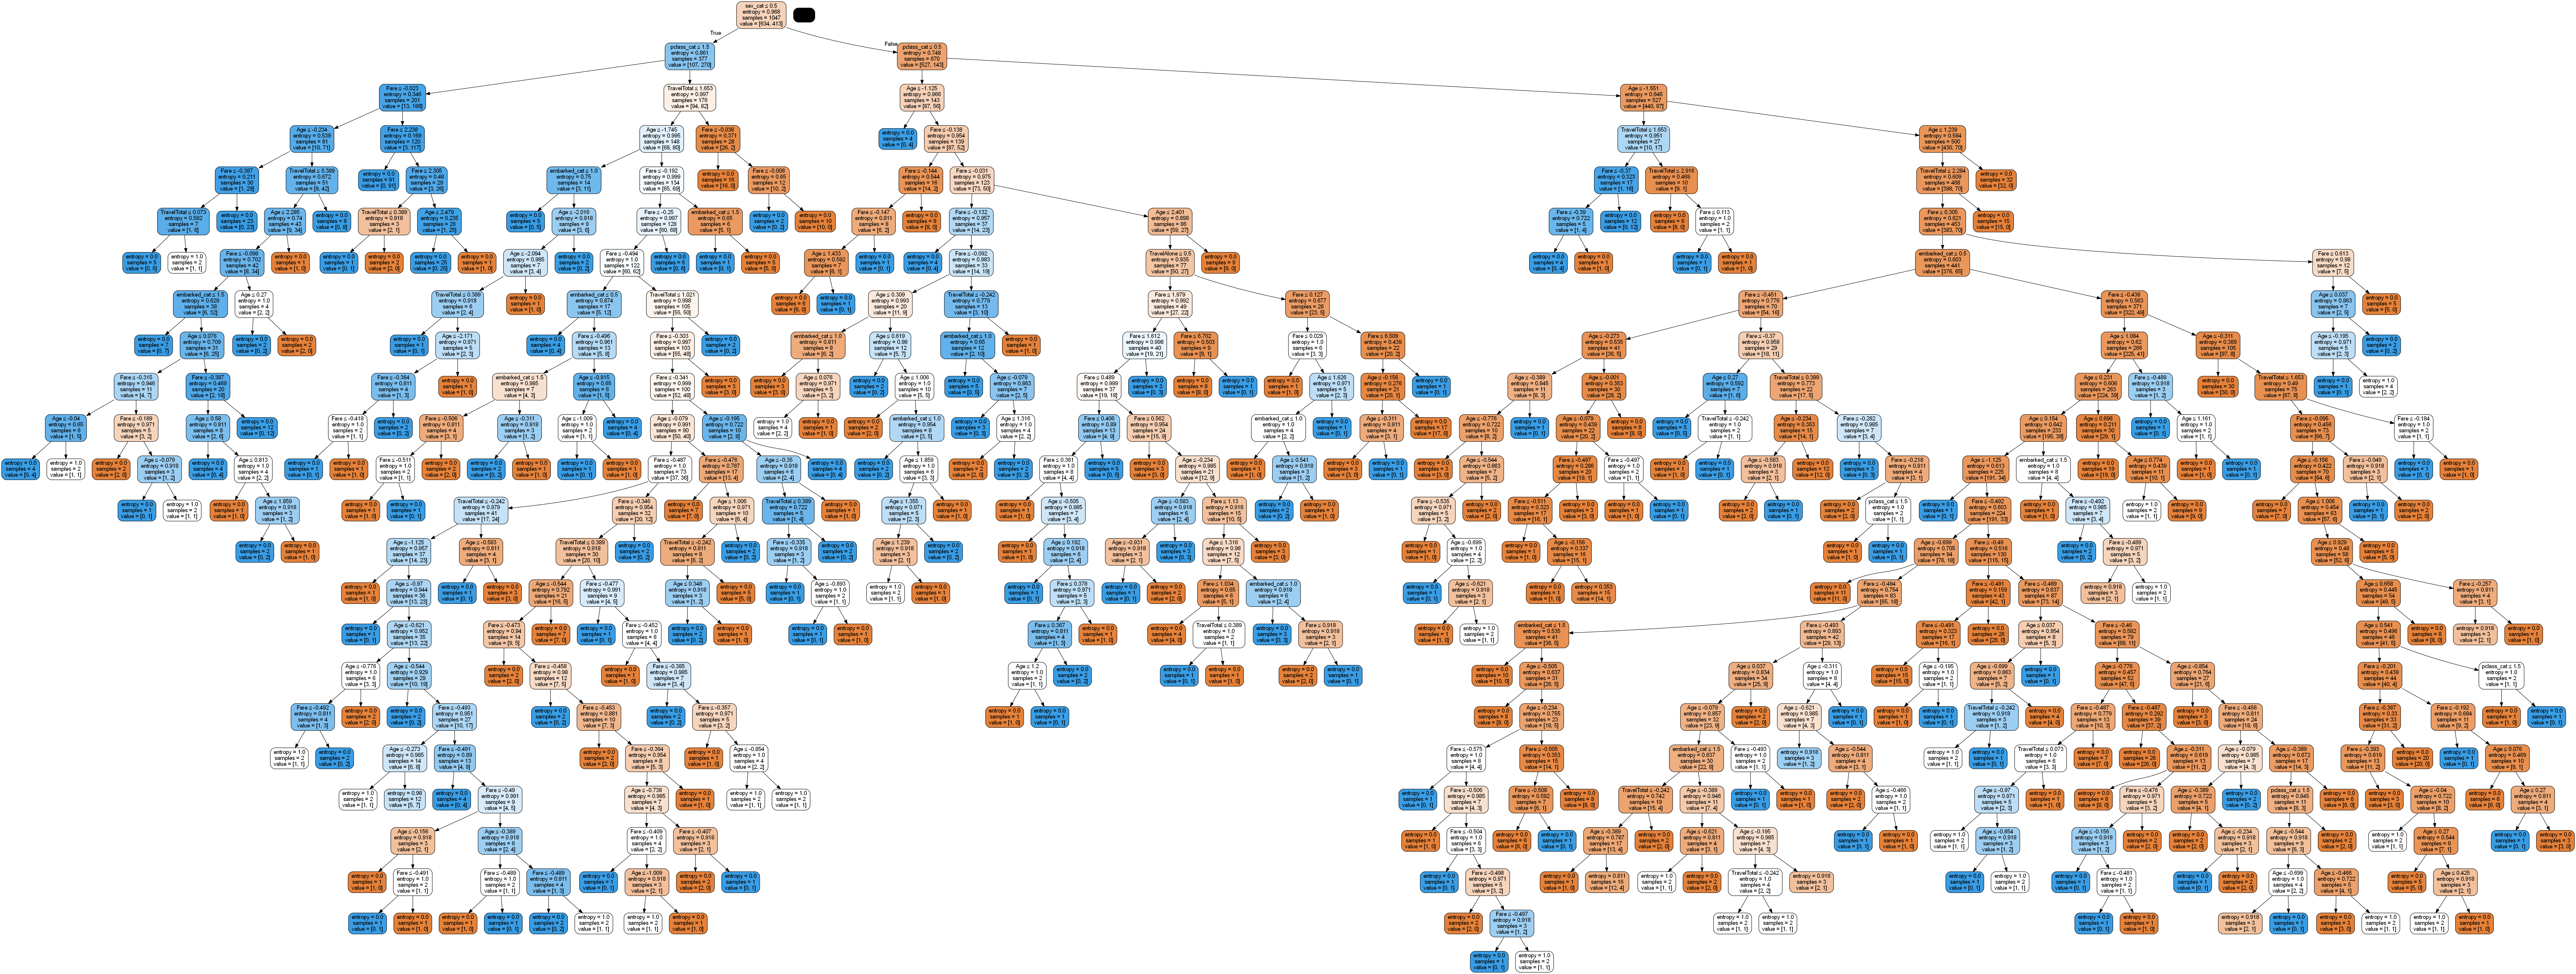

In [24]:
#DT1 Graph
names = ['pclass_cat','sex_cat','Age','Fare','embarked_cat','TravelAlone','TravelTotal']
visualize_tree(tree,names)

In [25]:
print(tree.feature_importances_)

[0.11690523 0.20484694 0.28166066 0.2825092  0.02957485 0.0047877
 0.07971542]


In [26]:
high_importance = ['sex_cat','Age','Fare']
X_train2 = X_train[high_importance]
X_test2 = X_test[high_importance]

In [27]:
#DT2 - Top 3 features only
#Initialize + fit model
tree2 = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, random_state=5).fit(X_train2, y_train)

#Predictions 
y_pred2 = tree2.predict(X_test2)

#Accuracy Score
tree_imp_accuracy = accuracy_score(y_test, y_pred2)
print('Decision Tree Accuracy with high importance attributes: {0:.2f}'.format(tree_imp_accuracy))

Decision Tree Accuracy with high importance attributes: 0.79


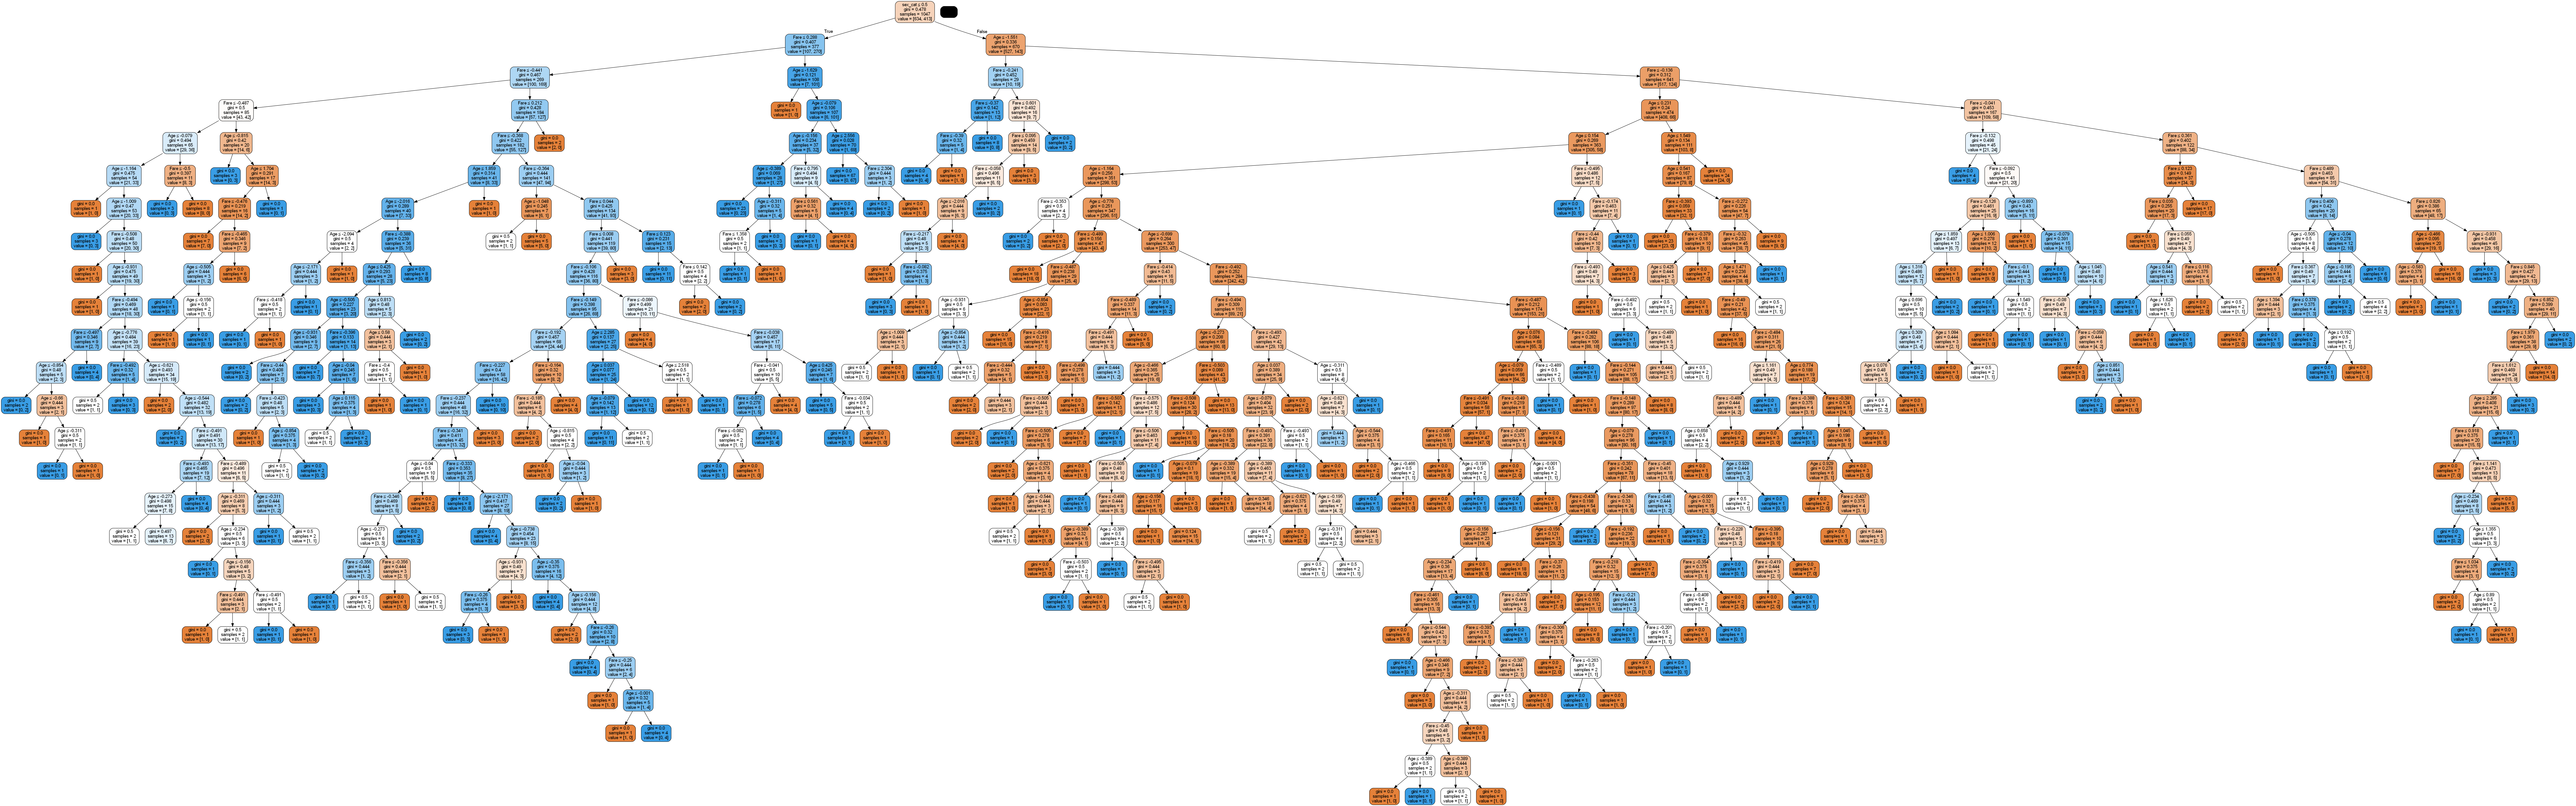

In [28]:
#DT2 Graph
visualize_tree(tree2,high_importance)

### Random Forest

In [29]:
#RF1 - All attributes
#Initalize + fit model
clf = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train, y_train)

#Predictions
y_pred = clf.predict(X_test)

#Accuracy Score
RF_all_accuracy = accuracy_score(y_test,y_pred)
print('Random Forest Accuracy with all attributes: {0:.2f}'.format(RF_all_accuracy))

Random Forest Accuracy with all attributes: 0.84


In [30]:
print(clf.feature_importances_)

[0.08291989 0.22912109 0.27371459 0.30343653 0.03344212 0.01295753
 0.06440824]


In [31]:
#RF2 - Top 3 features only
#Initialize + fit model
clf2 = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train2, y_train)

#Predictions
y_pred2 = clf2.predict(X_test2)

#Accuracy Score
RF_imp_accuracy = accuracy_score(y_test,y_pred2)
print('Random Forest Accuracy with high importance attributes: {0:.2f}'.format(RF_imp_accuracy))

Random Forest Accuracy with high importance attributes: 0.79


### Neural Network

In [32]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    # set random seed for reproducibility
    seed(42)

    model = Sequential()
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    # add dropout, default is none
    model.add(Dropout(dr))
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [33]:
#Initialize and create model
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
#Train neural
nn = model.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size=32, verbose=0)
nn_accuracy = np.mean(nn.history['val_accuracy'])

In [35]:
#Summarize history of accuracy
plt.plot(nn.history['accuracy'])
plt.plot(nn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [36]:
%pylab inline
plt.show()

C:\Users\x239757\AppData\Local\Temp\ipykernel_12304\2122436968.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Compare Accuracy Scores


In [37]:
#All Accuracies
print('NB accuracy: {0:.2f}'.format(NB_all_accuracy))

print("Decision Tree:")
print('All attributes: {0:.2f}'.format(tree_all_accuracy))
print('High importance attributes: {0:.2f}'.format(tree_imp_accuracy))

print("Random Forest:")
print('All attributes: {0:.2f}'.format(RF_all_accuracy))
print('High importance attributes: {0:.2f}'.format(RF_imp_accuracy))

print("Neural Network: ")
print('All attributes: {0:.2f}'.format(nn_accuracy))

NB accuracy: 0.81
Decision Tree:
All attributes: 0.78
High importance attributes: 0.79
Random Forest:
All attributes: 0.84
High importance attributes: 0.79
Neural Network: 
All attributes: 0.72


In [38]:
print(1)

1
